<a href="https://colab.research.google.com/github/Leopalds/metodo-rigidez/blob/main/MAC023-Trabalho2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolução de Vigas, treliças e pórticos planos

**Alunos**: Gustavo Carvalhaes (20206552B) e Pedro Leopoldo (202065518B)

Para resolução desse trabalho, utilizamos como base a apostila [Analise Estrutural III](https://drive.google.com/file/d/1DcRN9M0jFImnP3MBz5TnRiBGJnoxhLOo/view) e a instrução para o [trabalho final](https://drive.google.com/file/d/1BVnfMy4CI2yR2WV4rEEsfKoP4dLQ1guo/view?usp=sharing)

In [496]:
## Importações que serão utilizadas
import numpy as np
import math
import json
import matplotlib.pyplot as plt

# Resolução do Problema

## Definição das Classes de Barras

A primeira etapa do desenvolvimento foi a criação das classes definidas para os três tipos de estruturas a serem implementadas no trabalho. Todas as classes de barras recebem informações pertinentes da geometria da estrutura e do tipo de material e possuem funções para calcular as matrizes de rigidez local e de rotação.

Além de contar com funções para calcular o comprimento e angulo com o eixo global.

In [539]:
class BarraPorticoPlano:
    def __init__(self, id, coordNoInic, coordNoFim, A, I, E):
      self.id = id # identificador da barra
      self.coordNoInic = np.array(coordNoInic)
      self.coordNoFim = np.array(coordNoFim)
      self.A = A # area da seção transversal (m²)
      self.I = I # momento de inércia da seção (m⁴)
      self.E = E # módulo de elasticidade do material (Pa)
      self.L = self.calcularComprimento()
      self.angulo = self.calcularAngulo()

    def calcularComprimento(self):
      return np.linalg.norm(self.coordNoFim - self.coordNoInic) # distância euclidiana

    def calcularAngulo(self):
      distX = self.coordNoFim[0] - self.coordNoInic[0]
      distY = self.coordNoFim[1] - self.coordNoInic[1]
      return np.arctan2(distY, distX) # ângulo em rad

    def matrizRigidezLocal(self):
      # matriz de rigidez local (tabelada)
      L = self.L
      E = self.E
      A = self.A
      I = self.I
      k = [
          [ E*A/L,  0,          0,         -E*A/L,  0,         0       ],
          [ 0,      12*E*I/L**3, 6*E*I/L**2, 0,     -12*E*I/L**3, 6*E*I/L**2 ],
          [ 0,      6*E*I/L**2,  4*E*I/L,   0,     -6*E*I/L**2,  2*E*I/L   ],
          [-E*A/L,  0,          0,          E*A/L,  0,         0       ],
          [ 0,     -12*E*I/L**3, -6*E*I/L**2, 0,      12*E*I/L**3, -6*E*I/L**2],
          [ 0,      6*E*I/L**2,  2*E*I/L,   0,     -6*E*I/L**2,  4*E*I/L   ]
      ]
      return k
    def matrizRotacao(self):
      # matriz de rotação local
      cx = np.cos(self.angulo)
      cy = np.sin(self.angulo)

      R = np.array([
          [ cx,  cy,  0,  0,  0,  0],
          [-cy,  cx,  0,  0,  0,  0],
          [ 0,  0,  1,  0,  0,  0],
          [ 0,  0,  0,  cx,  cy,  0],
          [ 0,  0,  0, -cy,  cx,  0],
          [ 0,  0,  0,  0,  0,  1]
      ])

      return R

    def imprimirBarra(self):
      print(f"ID: {self.id}, NoI: {self.coordNoInic}, NoF: {self.coordNoFim}, L: {self.L:.2f}, Ângulo: {self.angulo:.2f}, A: {self.A:.2f}, I: {self.I:.2e}, E: {self.E:.2e}")

In [498]:
class BarraTrelicaPlana:
    def __init__(self, id, coordNoInic, coordNoFim, A, E):
      self.id = id
      self.coordNoInic = np.array(coordNoInic)
      self.coordNoFim = np.array(coordNoFim)
      self.A = A
      self.E = E
      self.L = self.calcularComprimento()
      self.angulo = self.calcularAngulo()

    def calcularComprimento(self):
      return np.linalg.norm(self.coordNoFim - self.coordNoInic) # distância euclidiana

    def calcularAngulo(self):
      distX = self.coordNoFim[0] - self.coordNoInic[0]
      distY = self.coordNoFim[1] - self.coordNoInic[1]
      return np.arctan2(distY, distX) # ângulo em rad

    def matrizRotacao(self):
      cx = np.cos(self.angulo)
      cy = np.sin(self.angulo)

      R = np.array([
          [ cx,  cy,  0,  0],
          [-cy,  cx,  0,  0],
          [ 0,  0,  cx,  cy],
          [ 0,  0, -cy,  cx]
      ])
      return R

    def matrizRigidezLocal(self):
      EA_L = (self.E * self.A) / self.L

      kLocal = np.array([
          [ 1,  0, -1,  0],
          [ 0,  0,  0,  0],
          [-1,  0,  1,  0],
          [ 0,  0,  0,  0]
      ]) * EA_L

      return kLocal

    def imprimirBarra(self):
        print(f"ID: {self.id}, NoI: {self.coordNoInic}, NoF: {self.coordNoFim}, L: {self.L:.2f}, Ângulo: {self.angulo:.2f}, A: {self.A:.2f}, E: {self.E:.2e}")


In [499]:
class BarraVigaPlana:
    def __init__(self, id, coordNoInic, coordNoFim, A, I, E):
      self.id = id
      self.coordNoInic = np.array(coordNoInic)
      self.coordNoFim = np.array(coordNoFim)
      self.A = A
      self.I = I
      self.E = E
      self.L = self.calcularComprimento()
      self.angulo = self.calcularAngulo()

    def calcularComprimento(self):
      return np.linalg.norm(self.coordNoFim - self.coordNoInic)

    def calcularAngulo(self):
      distX = self.coordNoFim[0] - self.coordNoInic[0]
      distY = self.coordNoFim[1] - self.coordNoInic[1]
      return np.arctan2(distY, distX)

    def matrizRotacao(self):
      cx = np.cos(self.angulo)
      cy = np.sin(self.angulo)

      R = np.array([
          [ cx,  cy,  0,  0],
          [-cy,  cx,  0,  0],
          [ 0,  0,   cx,  cy],
          [ 0,  0,  -cy,  cx],
      ])
      return R

    def matrizRigidezLocal(self):
      L = self.L
      E = self.E
      I = self.I

      kLocal = np.array([
          [ 12*E*I/L**3,  6*E*I/L**2, -12*E*I/L**3,  6*E*I/L**2],
          [ 6*E*I/L**2,   4*E*I/L,    -6*E*I/L**2,   2*E*I/L  ],
          [-12*E*I/L**3, -6*E*I/L**2,  12*E*I/L**3, -6*E*I/L**2],
          [ 6*E*I/L**2,   2*E*I/L,    -6*E*I/L**2,   4*E*I/L  ]
      ])

      return kLocal

    def imprimirBarra(self):
        print(f"ID: {self.id}, NoI: {self.coordNoInic}, NoF: {self.coordNoFim}, L: {self.L:.2f}, Ângulo: {self.angulo:.2f}, A: {self.A:.2f}, I: {self.I:.2e}, E: {self.E:.2e}")

## Entrada de dados

A entrada de dados foi implementada da forma como foi sugerido pelo texto da atividade final da disciplina, utilizamos o formato sugerido e as nomenclaturas. O código recebe um arquivo de texto o qual deve conter todas as informações necessárias. Após a extração de dados, o algoritmo faz uma série da validações das informações antes de prosseguir.

In [500]:
def read_data_json(filename):
    # Abre e carrega o arquivo JSON
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Extração dos parâmetros principais, garantindo que existam no JSON
    try:
        nno        = int(data["nno"])
        nel        = int(data["nel"])
        nnoel      = int(data["nnoel"])
        ndofn      = int(data["ndofn"])
        ntm        = int(data["ntm"])
        nts        = int(data["nts"])
        typestruct = int(data["typestruct"])
    except KeyError as e:
        raise Exception(f"Atenção: a chave {e} não foi encontrada no JSON")

    # Validação da lista de coordenadas (no JSON a chave é 'coord')
    coord_list = data.get("coord")
    if coord_list is None:
        raise Exception("Atenção: chave 'coord' não encontrada no JSON")
    if len(coord_list) != nno:
        raise Exception("Atenção: número de nós em 'coord' diferente de nno.")

    # Validação da conectividade dos elementos
    ndn_list = data.get("ndn")
    if ndn_list is None:
        raise Exception("Atenção: chave 'ndn' não encontrada no JSON")
    if len(ndn_list) != nel:
        raise Exception("Atenção: número de elementos em 'ndn' diferente de nel.")

    # Validação dos tipos de material
    intm_list = data.get("intm")
    if intm_list is None:
        raise Exception("Atenção: chave 'intm' não encontrada no JSON")
    if len(intm_list) != nel:
        raise Exception("Atenção: lista 'intm' com tamanho diferente de nel.")

    # Validação dos tipos de seção
    ints_list = data.get("ints")
    if ints_list is None:
        raise Exception("Atenção: chave 'ints' não encontrada no JSON")
    if len(ints_list) != nel:
        raise Exception("Atenção: lista 'ints' com tamanho diferente de nel.")

    # Validação das propriedades do material
    E_list = data.get("E")
    if E_list is None:
        raise Exception("Atenção: chave 'E' não encontrada no JSON")
    if len(E_list) != ntm:
        raise Exception("Atenção: número de valores de E diferente de ntm.")

    nu_list = data.get("nu")
    if nu_list is None:
        raise Exception("Atenção: chave 'nu' não encontrada no JSON")
    if len(nu_list) != ntm:
        raise Exception("Atenção: número de valores de nu diferente de ntm.")

    rho_list = data.get("rho")
    if rho_list is None:
        raise Exception("Atenção: chave 'rho' não encontrada no JSON")
    if len(rho_list) != ntm:
        raise Exception("Atenção: número de valores de rho diferente de ntm.")

    # Validação das propriedades da seção
    A_list = data.get("A")
    if A_list is None:
        raise Exception("Atenção: chave 'A' não encontrada no JSON")
    if len(A_list) != nts:
        raise Exception("Atenção: número de valores de A diferente de nts.")

    # A inércia pode estar como 'Iz' ou 'I'
    if "Iz" in data:
        Iz_list = data.get("Iz")
    elif "I" in data:
        Iz_list = data.get("I")
    else:
        raise Exception("Atenção: chave 'Iz' ou 'I' não encontrada no JSON")
    if len(Iz_list) != nts:
        raise Exception("Atenção: número de valores de Iz/I diferente de nts.")

    sf_list = data.get("sf")
    if sf_list is None:
        raise Exception("Atenção: chave 'sf' não encontrada no JSON")
    if len(sf_list) != nts:
        raise Exception("Atenção: número de valores de sf diferente de nts.")

    # Cálculo do módulo de elasticidade transversal G para cada material
    G_list = []
    for E_val, nu_val in zip(E_list, nu_list):
        G_list.append(E_val / (2 * (1 + nu_val)))

    # Organiza os dados em um dicionário, padronizando a chave de coordenadas para 'coor'
    new_data = {
        'nno': nno,
        'nel': nel,
        'nnoel': nnoel,
        'ndofn': ndofn,
        'ntm': ntm,
        'nts': nts,
        'typestruct': typestruct,
        'coor': coord_list,  # renomeia 'coord' para 'coor'
        'ndn': ndn_list,
        'intm': intm_list,
        'ints': ints_list,
        'E': E_list,
        'nu': nu_list,
        'rho': rho_list,
        'A': A_list,
        'Iz': Iz_list,
        'sf': sf_list,
        'G': G_list
    }

    return new_data

## Instanciando as barras

Após a primeira entrada de dados, o algoritmo segue para a instância das barras. Com uma lista de barras inicialmente vazio, realizamos o loop para o número de elementos indicado pelo usuário. Dentro da lógica do loop, obtemos os dados fornecidos para a barra e ao final instanciamos a classe específica da barra, a depender do tipo de estrutura definido, e adicionamos o objeto de barra na lista de barras.

In [537]:
def instanciar_barras(nel, ints, intm, Iz, E, A, ndn, coor, typestruct):
  barras = []
  for i in range(nel):
    #Pegando a area da barra
    indiceArea = ints[i]
    area = A[indiceArea - 1]

    # Pegando o Iz
    indiceI = intm[i]
    Iz_value = Iz[indiceI - 1]

    # Pegando o E
    indiceE = intm[i]
    E_value = E[indiceE - 1]

    # Pegando as coordenadas dos nos
    indiceNoIncial, indiceNoFinal = ndn[i]
    noInicial = coor[indiceNoIncial - 1]
    noFinal = coor[indiceNoFinal - 1]

    if(typestruct == 1):
      # Viga
      barras.append(BarraVigaPlana(i, noInicial, noFinal, area, Iz_value, E_value))
      barras[i].imprimirBarra()
    elif(typestruct == 2):
      # Treliça
      barras.append(BarraTrelicaPlana(i, noInicial, noFinal, area, E_value))
      barras[i].imprimirBarra()
    elif(typestruct == 3):
      # Portico
      barras.append(BarraPorticoPlano(i, noInicial, noFinal, area, Iz_value, E_value))
      barras[i].imprimirBarra()
    else:
      raise Exception("Tipo desconhecido")


  return barras

## Calculo da matriz global

### Rotina para montar o vetor LM

Utilizamos essa função para montar o vetor LM, primeiramente calculamos o número total de graus de liberdade, depois é calculado qual o primeiro grau de liberdade do elemento. Por fim instanciamos o vetor LM com início a partir de onde foi calculado e fim no último grau de liberdade


In [502]:
def calculo_vetor_LM(idNoInicio, idNoFim, nnoel, ndofn):
  # Calculando o número de dofs por elemento
    ids_nos_da_barra = [idNoInicio, idNoFim]
    vetor_LM = np.zeros(nnoel * ndofn, dtype=np.int8)

    # preenchendo o vetor LM
    for i in range(nnoel):
      for j in range(ndofn):
        vetor_LM[j + ndofn*i] = (ids_nos_da_barra[i] - 1) * ndofn + j + 1

    return vetor_LM

### Rotina para colocar a matriz de rigidez local na global

Nessa função de montagem, percorremos os graus de liberdade duas vezes, uma iterando pelas linhas e a outra pelas colunas. Para cada grau de liberdade identificamos a posição linha/coluna na matriz global. Uma vez localizado, fazemos a soma do valor da matriz local na posição da matriz global


In [503]:
def assembly(kk, k, vetor_LM):
    # Número de graus de liberdade por elemento
    edof = len(vetor_LM)

    # Montagem da matriz do sistema
    for i in range(edof):
        ii = vetor_LM[i] - 1
        for j in range(edof):
            jj = vetor_LM[j] - 1
            kk[ii, jj] += k[i, j]  # Adiciona o valor de k na matriz do sistema

    return kk

### Montagem da matriz global

Inicializamos uma matriz de tamanho número de nós X número de graus de liberdade por nó com zeros. Em seguida, para cada barra recuperamos a matriz de rotação, matriz de rigidez local, que é rotacionada para o referencial global atravéz da multiplicação pela matriz de rotação e pela matriz de rotação transposta. Por fim utilizamos a função de calculo de vetor LM já apresentada e a chamada da montagem da matriz global.


In [504]:
def monta_matriz_global(barras, nno, ndofn, nnoel, ndn):
  matriz_global = np.zeros((nno * ndofn, nno * ndofn))

  for (i, barra) in enumerate(barras):
    matrizRotacao = np.array(barra.matrizRotacao())
    matrizRigidezRotacionada = matrizRotacao.T @ barra.matrizRigidezLocal() @ matrizRotacao
    noInicial, noFinal = ndn[barra.id]
    vetor_lm = calculo_vetor_LM(noInicial, noFinal, nnoel, ndofn)
    matriz_global = assembly(matriz_global, matrizRigidezRotacionada, vetor_lm)

  return matriz_global

## Finalizar a entrada de dados

Nesta etapa, vamos ler o restante da entrada de dados do problema, o arquivo de entrada precisa ser no formato JSON. Obtemos as informações sobre os carregamentos e apoios. Além disso, também são feitas validações para verificar se o arquivo utilizado é um arquivo válido.


In [505]:
def ler_cargas_struct(filename, num_nodes, num_elements, ndofn):
    """
    Lê e valida os dados de carregamento de um arquivo JSON.

    :param filename: Nome do arquivo JSON com as informações de cargas.
    :param num_nodes: Número total de nós no modelo (para checar limites).
    :param num_elements: Número total de elementos no modelo (para checar limites).
    :param ndofn: Graus de liberdade por nó (para checar o formato de ccno).
    :return: Dicionário com os dados de carregamento (se válido).
    :raises ValueError: Caso alguma inconsistência seja encontrada.
    """

    # 1. Leitura do arquivo JSON
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 2. Extração dos dados principais
    nnc   = data["nnc"]       # Número de nós com cargas concentradas
    nele  = data["nele"]      # Número de elementos carregados
    nnoc  = data["nnoc"]      # Lista com os índices dos nós carregados
    ccno  = data["ccno"]      # Lista com as cargas concentradas [nnc x ndofn]
    ndmbc = data["ndmbc"]     # Lista com os índices dos elementos carregados
    ityl0 = data["itylo"]     # Lista com os dados dos tipos de carga
    nccdesl = data["nccdesl"] # Número de nós com apoio
    nnr = data['nnr']         # Lista com os indíces dos nós com apoio
    itydisp = data['itydisp'] # Lista com qual grau de liberdade está restrito

    # 3. Validações básicas de tamanho
    # 3.1. nnc vs nnoc
    if len(nnoc) != nnc:
        raise ValueError(
            f"Inconsistência: nnc={nnc}, mas len(nnoc)={len(nnoc)}."
        )

    # 3.2. nnc vs ccno
    if len(ccno) != nnc:
        raise ValueError(
            f"Inconsistência: nnc={nnc}, mas len(ccno)={len(ccno)}."
        )
    # Checando se cada linha de ccno tem ndofn colunas
    for i, linha_ccno in enumerate(ccno, start=1):
        if len(linha_ccno) != ndofn:
            raise ValueError(
                f"Em ccno, a linha {i} deveria ter {ndofn} valores, mas tem {len(linha_ccno)}."
            )

    # 3.3. nele vs ndmbc
    if len(ndmbc) != nele:
        raise ValueError(
            f"Inconsistência: nele={nele}, mas len(ndmbc)={len(ndmbc)}."
        )

    # 3.4. nele vs ityl0
    if len(ityl0) != nele:
        raise ValueError(
            f"Inconsistência: nele={nele}, mas len(itylo)={len(ityl0)}."
        )

    if len(nnr) != nccdesl:
      raise ValueError(
            f"Inconsistência: nccdesl={nccdesl}, mas len(nnr)={len(nnr)}."
        )

    if len(itydisp) != nccdesl:
      raise ValueError(
            f"Inconsistência: nccdesl={nccdesl}, mas len(itydisp)={len(itydisp)}."
        )

    # 4. Validando intervalos de nós e elementos
    # 4.1. Índices de nós carregados
    for node_index in nnoc:
        if not (1 <= node_index <= num_nodes):
            raise ValueError(
                f"Nó carregado {node_index} fora do intervalo [1, {num_nodes}]."
            )

    # 4.2. Índices de elementos carregados
    for elem_index in ndmbc:
        if not (1 <= elem_index <= num_elements):
            raise ValueError(
                f"Elemento carregado {elem_index} fora do intervalo [1, {num_elements}]."
            )

    # 4.3. Índices de nós apoiados
    for node_index in nnr:
        if not (1 <= node_index <= num_nodes):
            raise ValueError(
                f"Nó apoiado {node_index} fora do intervalo [1, {num_nodes}]."
            )

    # 4.4. Tamanaho de graus de liberdade dós nos apoiados
    for (i, no_index) in enumerate(itydisp):
      if len(no_index) != ndofn:
        raise ValueError(
              f"Inconsistência: ndofn={ndofn}, mas len(itydisp[{i}])={len(no_index)}."
          )

    # 5. Validação dos tipos de carga
    # Definição dos campos obrigatórios para cada tipo
    # (Ajuste conforme suas necessidades reais de validação)
    tipos_carga = {
        1: ["type", "mag", "pos"],                # Força vertical no vão
        2: ["type", "mag", "pos"],                # Momento no vão
        3: ["type", "mag", "pos"],                # Força horizontal no vão
        4: ["type", "mag", "pos"],                # Torsor no vão
        5: ["type", "mag", "distanciaNo"],        # Forças de mesma magnitude
        6: ["type", "mag"],                       # Carga distribuída (todo vão)
        7: ["type", "mag", "posInicial", "posFinal"],  # Carga distribuída parcial
        8: ["type", "altura", "ladoAltura"]       # Carga triangular
    }

    # 5.1. Checando cada item de ityl0
    for i, item in enumerate(ityl0, start=1):
        load_type = item.get("type")
        if load_type is None:
            raise ValueError(f"Não foi especificado 'type' para a carga {i}.")

        if load_type not in tipos_carga:
            raise ValueError(
                f"Tipo de carga inválido: {load_type}. Deve ser um inteiro de 1 a 8."
            )

        # Checa se os campos obrigatórios existem
        campos_necessarios = tipos_carga[load_type]
        for campo in campos_necessarios:
            if campo not in item:
                raise ValueError(
                    f"Para 'type'={load_type}, o campo '{campo}' é obrigatório. "
                    f"Carga {i} está incompleta."
                )

        # Exemplo extra de validação de formato, se desejado:
        # (Por exemplo, se "pos" deve ser uma lista de 2 valores)
        if "pos" in campos_necessarios:
            pos = item["pos"]
            if not (isinstance(pos, list) and len(pos) == 2):
                raise ValueError(
                    f"Para 'type'={load_type}, 'pos' deve ser uma lista [x, y]."
                )
        if "posInicial" in campos_necessarios:
            if not (isinstance(item["posInicial"], list) and len(item["posInicial"]) == 2):
                raise ValueError(
                    f"Para 'type'={load_type}, 'posInicial' deve ser uma lista [x, y]."
                )
        if "posFinal" in campos_necessarios:
            if not (isinstance(item["posFinal"], list) and len(item["posFinal"]) == 2):
                raise ValueError(
                    f"Para 'type'={load_type}, 'posFinal' deve ser uma lista [x, y]."
                )

    return data

### Distância euclidiana

Essa função retorna a distância eucliadiana entre dois pontos

In [506]:
def distancia_entre_pontos(ponto1, ponto2):
    return math.sqrt((ponto2[0] - ponto1[0]) ** 2 + (ponto2[1] - ponto1[1]) ** 2)

## Função para plotar a estrutura

In [507]:
def plot_barras(barras, ndn, coor, ndofn, typestruct):
    fig, ax = plt.subplots(figsize=(8,8))

    # Plota cada barra como uma linha
    for barra in barras:
        x_values = [barra.coordNoInic[0], barra.coordNoFim[0]]
        y_values = [barra.coordNoInic[1], barra.coordNoFim[1]]
        ax.plot(x_values, y_values, marker='o', linewidth=2, label=f'Barra {barra.id}')
        # Anota o ID da barra no ponto médio
        mid_x = (barra.coordNoInic[0] + barra.coordNoFim[0]) / 2
        mid_y = (barra.coordNoInic[1] + barra.coordNoFim[1]) / 2
        ax.text(mid_x, mid_y, f'{barra.id}', color='red', fontsize=12)

    # Imprime os graus de liberdade associados ao no
    for i in range(len(coor)):
      grauLiberdadeText = ""
      for j in range(ndofn):
        grauLiberdadeText += f"d{i * ndofn + j + 1}"
        if(j != ndofn - 1):
          grauLiberdadeText += ", "

      ax.text(coor[i][0], coor[i][1], f'{grauLiberdadeText}', color='black', fontsize=8)


    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Plot das Barras e Conexões")
    ax.legend()
    ax.grid(True)
    ax.axis('equal')
    plt.show()

    if(typestruct == 1):
      print("Os grau de liberdade do liberdade do nó são: Translação em y e Momento, respectivamente")
    elif(typestruct == 2):
      print("Os grau de liberdade do liberdade do nó são: Translação em x e Translação em y, respectivamente")
    elif(typestruct == 3):
      print("Os grau de liberdade do liberdade do nó são: Translação em x, Translação em y e Momento, respectivamente")


## Montagem do vetor de forças

Neste momento vamos montar o vetor de forças que será utilizado no sistema de equações globais. Para isso precisamos das forças nodais e das forças aplicadas nos elementos.

### Contribuição das forças nodais

As forças nodais são colocadas diretamentes nas posições relacionadas ao grau de liberdade da qual ela corresponde.


In [508]:
def adiciona_forcas_nodais(ccno, nnoc, ndofn, F):
  #Forças que atuam nos nós
  for (i, forca) in enumerate(ccno):
    indiceForca = nnoc[i]

    for (j, valor_no_grau_de_lib) in enumerate(forca):
      indiceGrauDeLiberdade = (indiceForca - 1) * ndofn + j
      F[indiceGrauDeLiberdade] += valor_no_grau_de_lib

  return F

### Contribuição das forças aplicadas no elemento


Já as forças aplicadas no elemento são transformadas em forças equivalentes utilizando as ações de engastamento perfeito. Como dito no documento da apresentação do trabalho, foram restringidas as possibilidades de tipos de cargas no elemento. Assim, nesse trecho identificamos cada uma delas e pegamos os valores das forças correspondentes no nos e utilizamos para montar o vetor de forças.

Os carregamentos nos elementos permitidos são so seguintes:

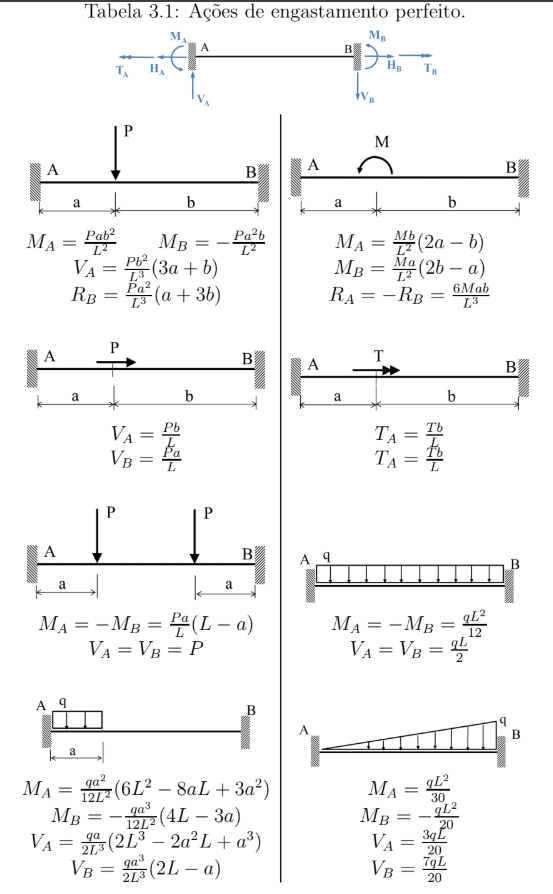

Depois de transformar as cargas no elemento em cargas equivalentes nos nós, é necessário fazer um mapeamento para colocar exatamente na posição correspondente do vetor de forças globais.

In [509]:
def adiciona_forcas_elemento(itylo, ndmbc, ndn, nnoel, ndofn, typestruct, F, barras):
  # Forças que atuam no elemento
  for (i, forca) in enumerate(itylo):
    if typestruct == 2:
      raise Exception("Treliças não tem carregamentos ao longo da barra, apenas nos nós")

    tipo_carga = forca['type']
    elementoId = ndmbc[i]
    barra = barras[elementoId - 1]
    L = barra.L           # comprimento barra
    noInicial = barra.coordNoInic
    ids_nos_da_barra = ndn[elementoId-1]

    # força equivalente local
    feq = np.zeros(nnoel * ndofn)


    if tipo_carga == 1:
          P = forca["mag"]       # Magnitude da força
          posicao = forca["pos"]    # posição

          #encontrando o a
          a = distancia_entre_pontos(noInicial, posicao)
          b = L - a

          # Usando a tabela
          VA = P * b**2 / L**3 * (3*a + b)
          VB = P * a**2 /L**3 * (a + 3*b)
          # Momentos (verifique com a tabela de engastamento perfeito!)
          MA = (P * a* b**2)/L**2
          MB = -(P*a**2*b)/L**2

          if(typestruct == 1):
            feq[0] = VA
            feq[1] = MA
            feq[2] = VB
            feq[3] = MB
          else:
            feq[1] = VA
            feq[2] = MA
            feq[4] = VB
            feq[5] = MB
    elif tipo_carga == 2:
        M = forca["mag"]
        posicao = forca["pos"]    # posição

        #encontrando o a
        a = distancia_entre_pontos(noInicial, posicao)
        b = L - a
        MA = M*b/L**2 * (2*a - b)
        MB = M*a/L**2 * (2*b - a)
        VA = (6*M*a*b) / L**3
        VB = - VA
        if(typestruct == 1):
            feq[0] = VA
            feq[1] = MA
            feq[2] = VB
            feq[3] = MB
        else:
          feq[1] = VA
          feq[2] = MA
          feq[4] = VB
          feq[5] = MB

    elif tipo_carga == 3:
        P = forca["mag"]
        posicao = forca["pos"]    # posição

        #encontrando o a
        a = distancia_entre_pontos(noInicial, posicao)
        b = L - a
        VA = P*b/L
        VB = P*a/L
        if(typestruct == 1):
            feq[0] = VA
            feq[2] = VB
        else:
          feq[1] = VA
          feq[4] = VB

    elif tipo_carga == 4:
        raise Exception("Não tratamos problema com torsor")

    elif tipo_carga == 5:
        P = forca["mag"]
        a = forca["distanciaNo"] #distancia a

        VA = VB = P
        MA = P*a/L*(L-a)
        MB = - MA
        if(typestruct == 1):
            feq[0] = VA
            feq[1] = MA
            feq[2] = VB
            feq[3] = MB
        else:
          feq[1] = VA
          feq[2] = MA
          feq[4] = VB
          feq[5] = MB

    elif tipo_carga == 6:
        # Carga distribuída q ao longo de todo o vão
        q = forca["mag"]
        VA = q*L/2.0
        MA = q*(L**2)/12.0
        VB = q*L/2.0
        MB = - q*(L**2)/12.0

        if(typestruct == 1):
            feq[0] = VA
            feq[1] = MA
            feq[2] = VB
            feq[3] = MB
        else:
          feq[0] = 0
          feq[1] = VA
          feq[2] = MA
          feq[3] = 0
          feq[4] = VB
          feq[5] = MB

    elif tipo_carga == 7:
        q = forca["mag"]
        posInicial = forca["posInicial"] #posicaoInicial
        posFinal = forca["posFinal"] #posicaoInicial
        a = distancia_entre_pontos(posInicial, posFinal)

        MA = q*a**2/(12*L**2) * (6*L**2 - 8*a*L + 3*a**2)
        MB = - q * a**3/(12* L**2) * (4*L - 3*a)
        VA = q*a/(2*L**3) * (2* L**3 - 2*a**2*L + a**3)
        VB = q*a**3/(2*L**3) * (2*L - a)

        ## caso o carregamento comece no meio da barra e vá até o final
        if(posInicial != noInicial):
          aux = MA
          MA = MB
          MB = aux
          aux = VA
          VA = VB
          VB = aux

        if(typestruct == 1):
            feq[0] = VA
            feq[1] = MA
            feq[2] = VB
            feq[3] = MB
        else:
          feq[1] = VA
          feq[2] = MA
          feq[4] = VB
          feq[5] = MB

    elif tipo_carga == 8:
        q = forca["altura"]
        ladoAltura = forca['ladoAltura']
        a = distancia_entre_pontos(posInicial, posFinal)

        MA = q*L**2/30
        MB = - q*L**2/20
        VA = 3*q*L/20
        VB = 7*q*L/20

        ## caso o maior lado do triangulo esteja a esquerda
        if(ladoAltura == 0):
          aux = MA
          MA = MB
          MB = aux
          aux = VA
          VA = VB
          VB = aux

        if(typestruct == 1):
            feq[0] = VA
            feq[1] = MA
            feq[2] = VB
            feq[3] = MB
        else:
          feq[1] = VA
          feq[2] = MA
          feq[4] = VB
          feq[5] = MB

    else:
        raise Exception(
            f"Tipo de carga {tipo_carga} ainda não implementado na função."
        )

    # se for inputado os graus deliberdade já no eixo global não precisa desse passo
    feq = barra.matrizRotacao() @ feq

    for ii in range(nnoel):
      GDLInicialGlobalDoNo = (ids_nos_da_barra[ii] - 1) * ndofn
      for jj in range(ndofn):
        F[GDLInicialGlobalDoNo + jj] += feq[jj + (ii * ndofn)]


  return F

## Tratando os apoios

Localizamos os graus de liberdade que estão restritos devido aos apoios e removemos suas respectivas linhas e colunas da matriz global, e removemos também a linha do vetor F

In [510]:
def tratando_apoios(nccdesl, itydisp, nnr, ndofn, matriz_global, F):
  apoios = np.zeros(nccdesl)
  restricoes = []

  for (i, graus_de_liberdade) in enumerate(itydisp) :
    indiceNo = nnr[i]

    for(j, restricao) in enumerate(graus_de_liberdade):
      # "remover" a linha e coluna relacionada a esse grau de liberdade
      grauDeLiberdadeGlobal = (indiceNo - 1) * ndofn + j

      if(restricao == 1):
        restricoes.append(grauDeLiberdadeGlobal)

  matriz_global_somente_incognitas = np.delete(matriz_global, restricoes, axis=0)
  matriz_global_somente_incognitas = np.delete(matriz_global_somente_incognitas, restricoes, axis=1)
  F_somente_incognitas = np.delete(F, restricoes)

  return matriz_global_somente_incognitas, F_somente_incognitas, restricoes

## Encontrando os deslocamentos

Como mostrado na apostila, os deslocamentos de cada um dos graus de liberdade que não estão restritos são encontrados a partir do seguinte sistema:

$$
[K]\{u\} = \{F\}
$$

Onde $K$ é a matriz de rigidez somente dos graus de liberdade não restritos,

$u$ é o vetor de deslocamentos dos graus de liberdade não restritos,

$F$ é o vetor das forças relacionadas com os graus de liberdade não restritos


Revolvemos o sistema utilizando a função solve da biblioteca do numpy do python

In [511]:
def encontra_deslocamentos(K, F):
  return np.linalg.solve(K, F)

## Cálculo das reações de apoio


Para o cálcluo das reações de apoio, vamos utilizar a seguinte relação:

$$
\{F_r\} = \{F_{RL}\}  + [K_{RD}]\{d\}
$$

Onde $\{F_r\}$ é o vetor das reações de apoio relacionadas ao grau de liberdade correspondente,

$\{F_{RL}\}$ é o vetor de forças relacionados com os graus de liberdade restritos,

$[K_{RD}]$ é uma matriz de rigidez que corresponde as linhas dos graus de liberdade restritos e as colunas dos graus de liberdade não restritos da matriz global

e $\{d\}$ é o vetor dos deslocamentos relacionados aos graus de liberdade livres

In [512]:
def calcula_reacoes_de_apoio(ndofn, nno, restricoes, F, matriz_global):
  graus_de_liberdade = np.arange(0, (ndofn * nno))
  graus_de_liberdade_restantes = np.setdiff1d(graus_de_liberdade, np.array(restricoes))

  matriz_para_reacoes_apoio = np.delete(matriz_global, graus_de_liberdade_restantes, axis=0)
  matriz_para_reacoes_apoio = np.delete(matriz_para_reacoes_apoio, restricoes, axis=1)
  F_para_reacoes_apoio = np.delete(F, graus_de_liberdade_restantes)
  print(matriz_para_reacoes_apoio, - F_para_reacoes_apoio)

  reacoes = - F_para_reacoes_apoio + (matriz_para_reacoes_apoio @  deslocamentos)
  return reacoes

## Cálculos dos esforços simples finais de extremidade elemento

@TODO

# Resolução de uma Viga



Agora vamos resolver o exemplo 2 da apostila.

As dimensões foram trocadas de t para KN.

Dados utilizados para resolução do problema:

$E = 1.67 \times 10^6 $ MPa

$v = 0.3$

$A = 0.18 m^2$

$I = 0.0054 m^4$



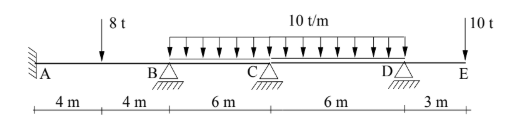

### Entrada de dados

In [513]:
filename = 'dados_modelo_ex2.json'
data = read_data_json(filename)
print(data)

{'nno': 5, 'nel': 4, 'nnoel': 2, 'ndofn': 2, 'ntm': 1, 'nts': 1, 'typestruct': 1, 'coor': [[0, 0], [8, 0], [14, 0], [20, 0], [23, 0]], 'ndn': [[1, 2], [2, 3], [3, 4], [4, 5]], 'intm': [1, 1, 1, 1], 'ints': [1, 1, 1, 1], 'E': [1670000], 'nu': [0.3], 'rho': [1], 'A': [0.18], 'Iz': [0.0054], 'sf': [1], 'G': [642307.6923076923]}


### Instancia barras

In [514]:
barras = instanciar_barras(data['nel'], data['ints'], data['intm'], data['Iz'] , data['E'], data['A'], data['ndn'], data['coor'], data['typestruct'])

ID: 0, NoI: [0 0], NoF: [8 0], L: 8.00, Ângulo: 0.00, A: 0.18, I: 5.40e-03, E: 1.67e+06
ID: 1, NoI: [8 0], NoF: [14  0], L: 6.00, Ângulo: 0.00, A: 0.18, I: 5.40e-03, E: 1.67e+06
ID: 2, NoI: [14  0], NoF: [20  0], L: 6.00, Ângulo: 0.00, A: 0.18, I: 5.40e-03, E: 1.67e+06
ID: 3, NoI: [20  0], NoF: [23  0], L: 3.00, Ângulo: 0.00, A: 0.18, I: 5.40e-03, E: 1.67e+06


## imprime barra

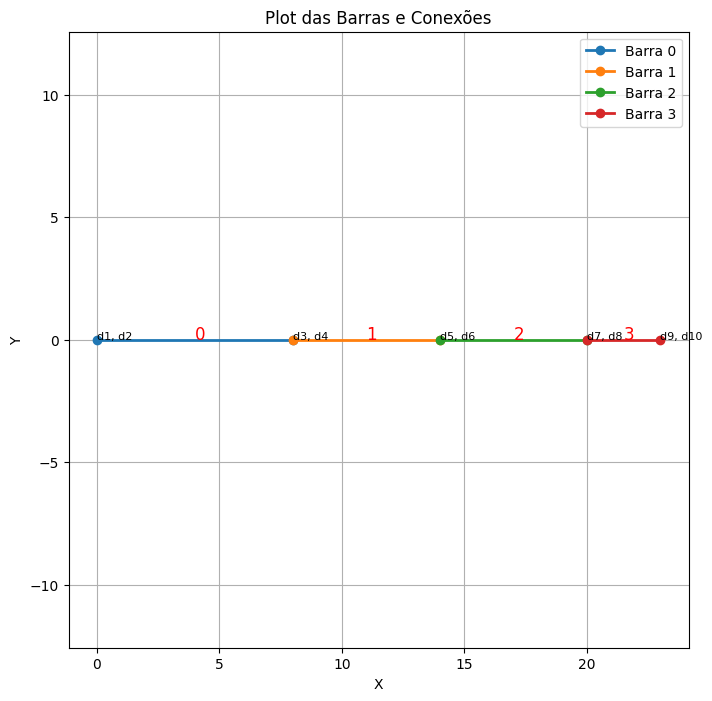

Os grau de liberdade do liberdade do nó são: Translação em y e Momento, respectivamente


In [515]:
plot_barras(barras, data['ndn'], data['coor'], data['ndofn'], data['typestruct'])

### matriz global

In [516]:
matriz_global = monta_matriz_global(barras, data['nno'], data['ndofn'], data['nnoel'], data['ndn'])

### Finalizando entrada de dados

In [517]:
dados_carregamento = ler_cargas_struct("cargas_ex2.JSON", data['nno'], data['nel'], data['ndofn'])
print(dados_carregamento)

{'nnc': 1, 'nele': 3, 'nnoc': [5], 'ccno': [[-10, 0]], 'ndmbc': [1, 2, 3], 'itylo': [{'type': 1, 'mag': -8, 'pos': [4, 0]}, {'type': 6, 'mag': -10}, {'type': 6, 'mag': -10}], 'nccdesl': 4, 'nnr': [1, 2, 3, 4], 'itydisp': [[1, 1], [1, 0], [1, 0], [1, 0]]}


### montagem vetor de forcas

In [518]:
F = np.zeros(data['nno']* data['ndofn'])
print(F)
F = adiciona_forcas_nodais(dados_carregamento['ccno'], dados_carregamento['nnoc'], data['ndofn'], F)
print(F)
F = adiciona_forcas_elemento(dados_carregamento['itylo'], dados_carregamento['ndmbc'], data['ndn'], data['nnoel'], data['ndofn'], data['typestruct'], F, barras)
print(F)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  0.   0.   0.   0.   0.   0.   0.   0. -10.   0.]
[ -4.  -8. -34. -22. -60.   0. -30.  30. -10.   0.]


### Tratando apoios

In [519]:
matriz_somente_icncognitas, F_somente_incognitas, restricoes = tratando_apoios(dados_carregamento['nccdesl'], dados_carregamento['itydisp'], dados_carregamento['nnr'], data['ndofn'], matriz_global, F)

## Encontrando deslocamentos

In [520]:
deslocamentos = encontra_deslocamentos(matriz_somente_icncognitas, F_somente_incognitas)
deslocamentos

array([-0.00227693,  0.00065055, -0.00032528, -0.01095587, -0.0053153 ])

### Reações de apoio

In [521]:
reacoes_de_apoio = calcula_reacoes_de_apoio(data['ndofn'], data['nno'], restricoes, F, matriz_global)
reacoes_de_apoio

[[  845.4375     0.         0.         0.         0.    ]
 [ 2254.5        0.         0.         0.         0.    ]
 [  657.5625  1503.         0.         0.         0.    ]
 [-1503.         0.      1503.         0.         0.    ]
 [    0.     -1503.      4509.     -4008.      6012.    ]] [ 4.  8. 34. 60. 30.]


array([ 2.075     ,  2.86666667, 33.48055556, 62.93333333, 39.51111111])

### Cálculo de esforços simples finais de extremidade elemento

In [522]:
# TODO

# Resolução de Treliça

Agora vamos resolver o exemplo 5 da apostila.

Dados utilizados para resolução do problema:

$E = 2.333333 \times 10^5 KN/m^2 $

$v = 0.3$

$A = 0.18 m^2$

$I = 0.0054 m^4$


### Entrada de dados

In [523]:
filename = 'dados_modelo_ex5.JSON'
data = read_data_json(filename)
print(data)

{'nno': 4, 'nel': 3, 'nnoel': 2, 'ndofn': 2, 'ntm': 1, 'nts': 1, 'typestruct': 2, 'coor': [[0, 0], [3, 0], [6, 0], [3, -4]], 'ndn': [[1, 4], [2, 4], [3, 4]], 'intm': [1, 1, 1], 'ints': [1, 1, 1], 'E': [233333.33], 'nu': [0.3], 'rho': [1], 'A': [0.18], 'Iz': [0.0054], 'sf': [1], 'G': [89743.58846153846]}


### Instancia barras

In [524]:
barras = instanciar_barras(data['nel'], data['ints'], data['intm'], data['Iz'] , data['E'], data['A'], data['ndn'], data['coor'], data['typestruct'])

# for i in range(len(barras)):
#   print(barras[i].matrizRigidezLocal())

ID: 0, NoI: [0 0], NoF: [ 3 -4], L: 5.00, Ângulo: -0.93, A: 0.18, E: 2.33e+05
ID: 1, NoI: [3 0], NoF: [ 3 -4], L: 4.00, Ângulo: -1.57, A: 0.18, E: 2.33e+05
ID: 2, NoI: [6 0], NoF: [ 3 -4], L: 5.00, Ângulo: -2.21, A: 0.18, E: 2.33e+05


## imprime a estrutura

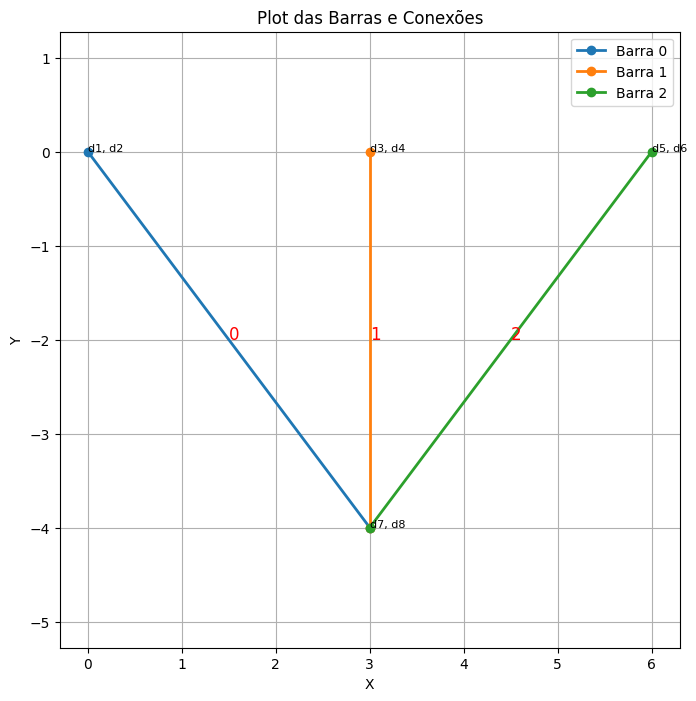

Os grau de liberdade do liberdade do nó são: Translação em x e Translação em y, respectivamente


In [525]:
plot_barras(barras, data['ndn'], data['coor'], data['ndofn'], data['typestruct'])

### matriz global

In [526]:
matriz_global = monta_matriz_global(barras, data['nno'], data['ndofn'], data['nnoel'], data['ndn'])
# print(matriz_global)
print(np.array2string(matriz_global, precision=2, separator=', ', formatter={'float_kind': lambda x: f"{x:.2f}"}))

[[3024.00, -4032.00, 0.00, 0.00, 0.00, 0.00, -3024.00, 4032.00],
 [-4032.00, 5376.00, 0.00, 0.00, 0.00, 0.00, 4032.00, -5376.00],
 [0.00, 0.00, 0.00, -0.00, 0.00, 0.00, -0.00, 0.00],
 [0.00, 0.00, -0.00, 10500.00, 0.00, 0.00, 0.00, -10500.00],
 [0.00, 0.00, 0.00, 0.00, 3024.00, 4032.00, -3024.00, -4032.00],
 [0.00, 0.00, 0.00, 0.00, 4032.00, 5376.00, -4032.00, -5376.00],
 [-3024.00, 4032.00, -0.00, 0.00, -3024.00, -4032.00, 6048.00, -0.00],
 [4032.00, -5376.00, 0.00, -10500.00, -4032.00, -5376.00, -0.00, 21252.00]]


### Finalizando entrada de dados

In [527]:
dados_carregamento = ler_cargas_struct("cargas_ex5.json", data['nno'], data['nel'], data['ndofn'])
print(dados_carregamento)

{'nnc': 1, 'nele': 0, 'nnoc': [4], 'ccno': [[100, -150]], 'ndmbc': [], 'itylo': [], 'nccdesl': 3, 'nnr': [1, 2, 3], 'itydisp': [[1, 1], [1, 1], [1, 1]]}


### montagem vetor de forcas

In [528]:
F = np.zeros(data['nno']* data['ndofn'])
F = adiciona_forcas_nodais(dados_carregamento['ccno'], dados_carregamento['nnoc'], data['ndofn'], F)
F = adiciona_forcas_elemento(dados_carregamento['itylo'], dados_carregamento['ndmbc'], data['ndn'], data['nnoel'], data['ndofn'], data['typestruct'], F, barras)
print(F)

[   0.    0.    0.    0.    0.    0.  100. -150.]


### Tratando apoios

In [529]:
matriz_somente_incognitas, F_somente_incognitas, restricoes = tratando_apoios(dados_carregamento['nccdesl'], dados_carregamento['itydisp'], dados_carregamento['nnr'], data['ndofn'], matriz_global, F)

print(matriz_somente_incognitas, F_somente_incognitas)

print(restricoes)

[[ 6.04799991e+03 -9.09494702e-13]
 [-9.09494702e-13  2.12519997e+04]] [ 100. -150.]
[0, 1, 2, 3, 4, 5]


## Encontrando deslocamentos

In [530]:
deslocamentos = encontra_deslocamentos(matriz_somente_incognitas, F_somente_incognitas)
deslocamentos

array([ 0.01653439, -0.00705816])

### Reações de apoio

In [531]:
reacoes_de_apoio = calcula_reacoes_de_apoio(data['ndofn'], data['nno'], restricoes, F, matriz_global)
reacoes_de_apoio

[[-3.02399996e+03  4.03199994e+03]
 [ 4.03199994e+03 -5.37599992e+03]
 [-3.93686937e-29  6.42939560e-13]
 [ 6.42939560e-13 -1.04999998e+04]
 [-3.02399996e+03 -4.03199994e+03]
 [-4.03199994e+03 -5.37599992e+03]] [-0. -0. -0. -0. -0. -0.]


array([-7.84584980e+01,  1.04611331e+02, -4.53796986e-15,  7.41106719e+01,
       -2.15415020e+01, -2.87220026e+01])

### Cálculo de esforços simples finais de extremidade elemento

In [532]:
# TODO

# Resolução de Pórtico

Agora vamos resolver o exemplo 6 da apostila.

Dados utilizados para resolução do problema:

$E = 3.2 \times 10^7 KN/m^2 $

$v = 0.3$

$A = 0.14 m^2$

$I = 0.005717 m^4$


### Entrada de dados

In [533]:
filename = 'dados_modelo_ex6.JSON'
data = read_data_json(filename)
print(data)

{'nno': 3, 'nel': 2, 'nnoel': 2, 'ndofn': 3, 'ntm': 1, 'nts': 1, 'typestruct': 3, 'coor': [[0, 0], [6, 0], [6, -3]], 'ndn': [[1, 2], [2, 3]], 'intm': [1, 1], 'ints': [1, 1], 'E': [32000000], 'nu': [0.3], 'rho': [1], 'A': [0.14], 'Iz': [0.005717], 'sf': [1], 'G': [12307692.307692308]}


### Instancia barras

In [540]:
barras = instanciar_barras(data['nel'], data['ints'], data['intm'], data['Iz'] , data['E'], data['A'], data['ndn'], data['coor'], data['typestruct'])

# for i in range(len(barras)):
#   print(barras[i].matrizRigidezLocal())

ID: 0, NoI: [0 0], NoF: [6 0], L: 6.00, Ângulo: 0.00, A: 0.14, I: 5.72e-03, E: 3.20e+07
ID: 1, NoI: [6 0], NoF: [ 6 -3], L: 3.00, Ângulo: -1.57, A: 0.14, I: 5.72e-03, E: 3.20e+07


## imprime a estrutura

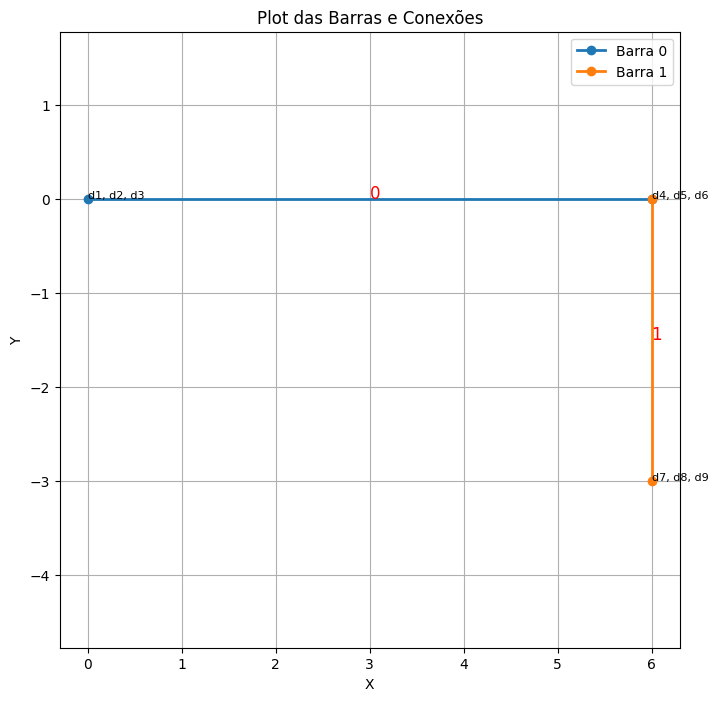

Os grau de liberdade do liberdade do nó são: Translação em x, Translação em y e Momento, respectivamente


In [541]:
plot_barras(barras, data['ndn'], data['coor'], data['ndofn'], data['typestruct'])

### matriz global

In [542]:
matriz_global = monta_matriz_global(barras, data['nno'], data['ndofn'], data['nnoel'], data['ndn'])
# print(matriz_global)
print(np.array2string(matriz_global, precision=2, separator=', ', formatter={'float_kind': lambda x: f"{x:.2f}"}))

[[746666.67, 0.00, 0.00, -746666.67, 0.00, 0.00, 0.00, 0.00, 0.00],
 [0.00, 10163.56, 30490.67, 0.00, -10163.56, 30490.67, 0.00, 0.00, 0.00],
 [0.00, 30490.67, 121962.67, 0.00, -30490.67, 60981.33, 0.00, 0.00, 0.00],
 [-746666.67, 0.00, 0.00, 827975.11, -0.00, 121962.67, -81308.44, 0.00,
  121962.67],
 [0.00, -10163.56, -30490.67, -0.00, 1503496.89, -30490.67, 0.00,
  -1493333.33, 0.00],
 [0.00, 30490.67, 60981.33, 121962.67, -30490.67, 365888.00, -121962.67,
  -0.00, 121962.67],
 [0.00, 0.00, 0.00, -81308.44, 0.00, -121962.67, 81308.44, -0.00,
  -121962.67],
 [0.00, 0.00, 0.00, 0.00, -1493333.33, -0.00, -0.00, 1493333.33, -0.00],
 [0.00, 0.00, 0.00, 121962.67, 0.00, 121962.67, -121962.67, -0.00,
  243925.33]]


### Finalizando entrada de dados

In [543]:
dados_carregamento = ler_cargas_struct("cargas_ex6.json", data['nno'], data['nel'], data['ndofn'])
print(dados_carregamento)

{'nnc': 1, 'nele': 1, 'nnoc': [2], 'ccno': [[80, -100, 0]], 'ndmbc': [1], 'itylo': [{'type': 6, 'mag': -40}], 'nccdesl': 2, 'nnr': [1, 3], 'itydisp': [[1, 1, 1], [1, 1, 1]]}


### montagem vetor de forcas

In [544]:
F = np.zeros(data['nno']* data['ndofn'])
F = adiciona_forcas_nodais(dados_carregamento['ccno'], dados_carregamento['nnoc'], data['ndofn'], F)
F = adiciona_forcas_elemento(dados_carregamento['itylo'], dados_carregamento['ndmbc'], data['ndn'], data['nnoel'], data['ndofn'], data['typestruct'], F, barras)
print(F)

[   0. -120. -120.   80. -220.  120.    0.    0.    0.]


### Tratando apoios

In [545]:
matriz_somente_incognitas, F_somente_incognitas, restricoes = tratando_apoios(dados_carregamento['nccdesl'], dados_carregamento['itydisp'], dados_carregamento['nnr'], data['ndofn'], matriz_global, F)

print(matriz_somente_incognitas, F_somente_incognitas)

print(restricoes)

[[ 8.27975111e+05 -8.64615880e-11  1.21962667e+05]
 [-8.64615880e-11  1.50349689e+06 -3.04906667e+04]
 [ 1.21962667e+05 -3.04906667e+04  3.65888000e+05]] [  80. -220.  120.]
[0, 1, 2, 6, 7, 8]


## Encontrando deslocamentos

In [546]:
deslocamentos = encontra_deslocamentos(matriz_somente_incognitas, F_somente_incognitas)
deslocamentos

array([ 5.26159196e-05, -1.40267113e-04,  2.98741649e-04])

### Reações de apoio

In [547]:
reacoes_de_apoio = calcula_reacoes_de_apoio(data['ndofn'], data['nno'], restricoes, F, matriz_global)
reacoes_de_apoio

[[-7.46666667e+05  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.01635556e+04  3.04906667e+04]
 [ 0.00000000e+00 -3.04906667e+04  6.09813333e+04]
 [-8.13084444e+04  8.64615880e-11 -1.21962667e+05]
 [ 8.64615880e-11 -1.49333333e+06 -7.46805947e-12]
 [ 1.21962667e+05  7.46805947e-12  1.21962667e+05]] [ -0. 120. 120.  -0.  -0.  -0.]


array([-39.28655331, 130.53444462, 142.49450184, -40.71344669,
       209.46555538,  42.85250598])

### Cálculo de esforços simples finais de extremidade elemento

In [ ]:
# TODO

# Exemplo portico



*   ✅ Instanciar os objetos que o Gustavo criou
  *   Criar a matriz local
*   ✅Criar a matriz global
  *    rotacionar e colocar a matriz local na global
*   ✅ Finalizar a entrada de dados
  *    Apoios
  *    Forças (geral momento tb) pontuais e carregamentos
*   ✅ Vetor de forças
  *    Vetor de cargas nodais equivalentes
        *   Engasmento perfeito com sinal trocado
  *   Cargas aplicadas diretamente sobre os nos
* ✅ Encontrar as reações de apoio
* Corrigir e testar para outros exemplos
  * Viga
    * Falta comparar com FTOOL
  * treliça
  * portico
* Imprimir as estruturas e os graus de liberdade
* Encontrar os esforços de cada barra
  * Cálculo de esforços simples finais de extremidade elemento
* Refatorar código
  * ▶ Montar relatório
  * ✅ Criar funções
  * ✅ Utilizar json na primeira leitura também


### Limitações:

- 2 elementos por barra apenas
- Elementos planos apenas
- Consideremos apenas apoios que restringem todo o deslocamento (ou rotação)